In [1]:
import matplotlib.pyplot as plt
import numpy as np

from helper_tools import *

from storage_ring_modeler import StorageRingModel,make_optimal_solution_model
from phaseSpaceAnalyzer import SwarmSnapShot
from phaseSpaceAnalysis_Functions import make_phase_space_info,plot_ring_lattice_with_stops,emittance_from_particles,get_emittances
from math import sqrt
from particle_class import Swarm
m=7.0
model=make_optimal_solution_model('2',use_bumper=False,include_mag_cross_talk=True)


def temperature(momenta,momenta_cutoff=1.0):
    momenta=values_up_to_cutoff_frac(momenta,momenta_cutoff)
    sigma=np.std(momenta)
    return (sigma/91)**2 * m

In [206]:
speed_longitudinal=208
def thermal_swarm(num_particles,temp_swarm,r_max):
    sigma=91*sqrt(temp_swarm/m)
    momentums=np.random.normal(loc=(-model.lattice_ring.speed_nominal,0.0,0.0),scale=sigma,size=(num_particles,3))
    positions=[]
    while len(positions)<num_particles:
        y,z=r_max*2*(np.random.random(2)-.5)
        if sqrt(y**2+z**2)<r_max:
            positions.append([-1e-10,y,z])
    swarm_initial=Swarm()
    for P,Q in zip(momentums,positions):
        swarm_initial.add_new_particle(np.array(Q),np.array(P))
    return swarm_initial

In [207]:
from phaseSpaceAnalysis_Functions import transfer_particles_to_new_swarm
%matplotlib inline
T_max_sim=30.0
x0=1e-6
num_particles=600
temperature_swarm=.005
r_max=.5e-3
_swarm_initial=thermal_swarm(num_particles,temperature_swarm,r_max)

x_max=T_max_sim*model.lattice_ring.speed_nominal
x_stops=np.arange(x0,x_max,model.lattice_ring.total_length)
phase_space_info=[[] for _ in x_stops]
work_size=40
swarm_traced=None
while len(_swarm_initial)>0:
    print(len(_swarm_initial))
    swarm_to_trace=transfer_particles_to_new_swarm(_swarm_initial,work_size)
    swarm_traced=model.swarm_tracer_ring.trace_swarm_through_lattice(swarm_to_trace,5e-6,T_max_sim,parallel=True,steps_per_logging=4 ,use_fast_mode=False)
    for info,x_snap in zip(phase_space_info,x_stops):
        snap=SwarmSnapShot(swarm_traced,x_snap)
        info.extend(snap.particles)

600


Process ForkPoolWorker-157:
Process ForkPoolWorker-151:
Process ForkPoolWorker-159:
Process ForkPoolWorker-152:
Process ForkPoolWorker-155:
Process ForkPoolWorker-153:
Process ForkPoolWorker-158:
Process ForkPoolWorker-160:
Process ForkPoolWorker-154:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/hom

KeyboardInterrupt: 

In [152]:
T_min_analysis=T_max_sim*.9
x_min = min([particle.qo[0] for particle in phase_space_info[-1] if particle.T > T_min_analysis])
def is_valid(particle):
    return (particle.T>T_min_analysis and particle.qo[0]<x_min)
len([particle for particle in phase_space_info[0] if is_valid(particle)]),x_min

(514, 6110.426716916681)

In [162]:
def _get_coords(idx,condition):
    y= np.array([part.qo[1] for part in phase_space_info[idx] if condition(part)])
    z= np.array([part.qo[2] for part in phase_space_info[idx] if condition(part)])
    py=np.array([part.po[1] for part in phase_space_info[idx] if condition(part)])
    pz=np.array([part.po[2] for part in phase_space_info[idx] if condition(part)])
    return y,z,py,pz

def get_coords(idx,enforce_only_survived=False):
    if enforce_only_survived:
        condition=is_valid
    else:
        condition=lambda particle: not particle.clipped
    return _get_coords(idx,condition)

In [172]:


# def get_valid_coords(idx):
#     y= np.array([part.qo[1] for part in phase_space_info[idx] if is_valid(part)])
#     z= np.array([part.qo[2] for part in phase_space_info[idx] if is_valid(part)])
#     py=np.array([part.po[1] for part in phase_space_info[idx] if is_valid(part)])
#     pz=np.array([part.po[2] for part in phase_space_info[idx] if is_valid(part)])
#     return y,z,py,pz

pyi,pzi=swarm_traced[:,'pi',1],swarm_traced[:,'pi',2]
temperatures=[[temperature(pyi),temperature(pzi)]]
num_particles=[]
# py_90=[]
# pz_90=[]
momenta_cutoff=1.0
end_offset=1
enforce_only_survived=False
for index,_ in enumerate(phase_space_info[:-end_offset]):
    _,_,py,pz=get_coords(index,enforce_only_survived=enforce_only_survived)
    if len(py)!=0:
        # py_90.append(val_at_cumulative_fraction(py,.9))
        # pz_90.append(val_at_cumulative_fraction(pz,.9))
        # py_90.append(RMS(values_up_to_cutoff_frac(py,.9)))
        num_particles.append(len(pz))
        Ty=temperature(py,momenta_cutoff=momenta_cutoff)
        Tz=temperature(pz,momenta_cutoff=momenta_cutoff)
        temperatures.append([Ty,Tz])
temperatures=np.array(temperatures)
survived_indices=list(range(len(temperatures)))
len(temperatures),temperatures[0]

(764, array([0.00524271, 0.00473032]))

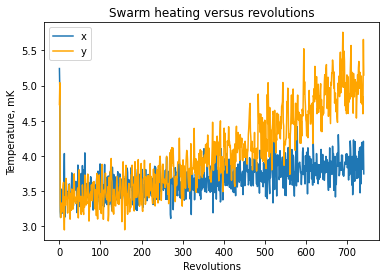

In [166]:
from scipy.signal import savgol_filter
plt.title("Swarm heating versus revolutions")
k_to_mk=1e3
plt.xlabel("Revolutions")
plt.ylabel("Temperature, mK")
y1=temperatures[:,0]*k_to_mk
y2=temperatures[:,1]*k_to_mk

# y1[1:]=savgol_filter(y1[1:],31,1)
# y2[1:]=savgol_filter(y2[1:],31,1)

plt.plot(y1,label='x')
plt.plot(y2,label='y',c='orange')
plt.legend()
plt.savefig('fig',dpi=300)
plt.show()

# plt.plot(num_particles)
# plt.xlabel("Revolutions")
# plt.ylabel("Number of surviving particles")
# plt.show()
# plt.plot(py_90,label='x')
# plt.plot(py_rms)
# # plt.plot(pz_90,label='y',c='orange')
# plt.ylabel("RMS velocity")
# plt.xlabel("revolutions")
# plt.show()

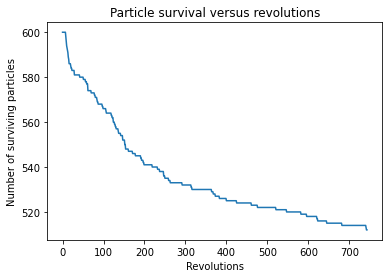

In [93]:
plt.title("Particle survival versus revolutions")
plt.plot(num_particles)
plt.xlabel("Revolutions")
plt.ylabel("Number of surviving particles")
plt.savefig('fig',dpi=300)

plt.show()


In [ ]:
plt.savefig('fig',dpi=300)

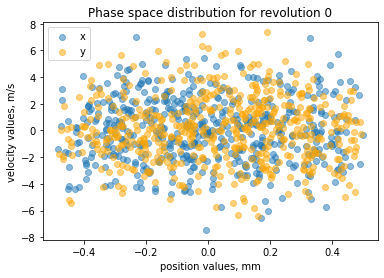

In [169]:
def plot_phase_space(idx):
    idx=survived_indices[idx]
    y,z,py,pz=get_coords(idx,enforce_only_survived=enforce_only_survived)
    y/=1e-3
    z/=1e-3
    plt.title("Phase space distribution for revolution "+str(idx))
    plt.scatter(y,py,label='x',alpha=.5)
    plt.scatter(z,pz,label='y',c='orange',alpha=.5)
    plt.xlabel("position values, mm")
    plt.ylabel("velocity values, m/s")
    plt.legend()
    plt.savefig('fig',dpi=300)
    plt.show()
plot_phase_space(0)

600


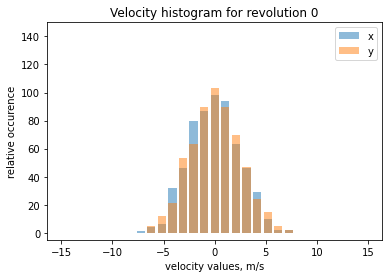

In [205]:
def plot_momenta_hist(idx):
    idx=survived_indices[idx]
    _,_,py,pz=get_coords(idx,enforce_only_survived=enforce_only_survived)
    print(len(py))
    plt.title("Velocity histogram for revolution "+str(idx))
    bins=np.linspace(-15,15,30)
    plot_x_vals=bins[:-1]+(bins[1]-bins[0])/2
    plt.bar(plot_x_vals,np.histogram(py,bins=bins)[0],label='x',alpha=.5)
    plt.bar(plot_x_vals,np.histogram(pz,bins=bins)[0],label='y',alpha=.5)
    plt.xlabel("velocity values, m/s")
    plt.ylabel("relative occurence")
    # plt.xlim([-15,15])
    plt.ylim([-5,150])
    plt.legend()
    plt.savefig('fig',dpi=300)
    plt.show()
plot_momenta_hist(0)